# Camera Setup

In [2]:
import cv2
import cv2.aruco as aruco
import os
import numpy as np
import subprocess

# Camera 0 refers to top camera, Camera 1 refers to bottom camera
# Ensure camera port ids are correct
port_ids = [2, 0]
cam0_device = f"/dev/cam0"
cam1_device = f"/dev/cam1"

# Ensure proper camera configurations
cam0_focus_value = 35
cam1_focus_value = 75
config_commands = {cam0_device: [
                    f"v4l2-ctl -d {cam0_device} -c focus_automatic_continuous=0",
                    f"v4l2-ctl -d {cam0_device} -c auto_exposure=3",
                    f"v4l2-ctl -d {cam0_device} -c focus_absolute={cam0_focus_value}",
                    # f"v4l2-ctl -d {device} -c exposure_time_absolute=333",
                    # f"v4l2-ctl -d {device} -c gain=0",
                    # f"v4l2-ctl -d {device} -c white_balance_automatic=0",
                    # f"v4l2-ctl -d {device} -c white_balance_temperature=4675",
                    # f"v4l2-ctl -d {device} -c brightness=128",
                    # f"v4l2-ctl -d {device} -c contrast=128",
                    # f"v4l2-ctl -d {device} -c saturation=128",
                    ],
                cam1_device: [
                    f"v4l2-ctl -d {cam1_device} -c focus_automatic_continuous=0",
                    f"v4l2-ctl -d {cam1_device} -c auto_exposure=3",
                    f"v4l2-ctl -d {cam1_device} -c focus_absolute={cam1_focus_value}",
                    # f"v4l2-ctl -d {device} -c exposure_time_absolute=333",
                    # f"v4l2-ctl -d {device} -c gain=0",
                    # f"v4l2-ctl -d {device} -c white_balance_automatic=0",
                    # f"v4l2-ctl -d {device} -c white_balance_temperature=4675",
                    # f"v4l2-ctl -d {device} -c brightness=128",
                    # f"v4l2-ctl -d {device} -c contrast=128",
                    # f"v4l2-ctl -d {device} -c saturation=128",
                    ]
                }

def configure_camera(devices, config_commands):
    for device in devices:

        print(f"Configuring camera on {device}...")

        for command in config_commands[device]:
            subprocess.run(command, shell=True, check=True)

        print("Camera configuration complete!")

# Grab some test images of catheter tip

In [4]:
# Collect images of calibration board in both cameras frames for stereo extrinsic calibration
import cv2
import datetime
import os

output_dir = f"../tip_pose_images/LC_v4"
os.makedirs(output_dir, exist_ok=True)

# Make sure cameras are configures
# configure_camera([cam0_device, cam1_device], config_commands) # Uncomment to use default configs
cap0 = cv2.VideoCapture(cam0_device, cv2.CAP_V4L2)
cap1 = cv2.VideoCapture(cam1_device, cv2.CAP_V4L2)
frame_count = 0
while True:
    # Read frames from both cameras
    ret0, frame0 = cap0.read()
    ret1, frame1 = cap1.read()

    if not ret0 or not ret1:
        print("Error: One or both frames could not be read.")
        break

    # Display both camera feeds with timestamps
    # timestamp = datetime.now().strftime("%H:%M:%S.%f")
    # cv2.putText(frame1, f"Cam1 - {timestamp}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    # cv2.putText(frame2, f"Cam2 - {timestamp}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Combine and display both frames
    combined = cv2.hconcat([frame0, frame1])
    cv2.imshow("Camera 0 (top) + Camera 1 (side)", combined)

    key = cv2.waitKey(1) & 0xFF

    if key == 27:  # ESC key to exit
        break
    elif key == ord(' '):  # Space key to capture images
        img0_path = f"{output_dir}/cam0_{frame_count}.png"
        img1_path = f"{output_dir}/cam1_{frame_count}.png"
        cv2.imwrite(img0_path, frame0)
        cv2.imwrite(img1_path, frame1)
        print(f"Captured images:\n - {img0_path}\n - {img1_path}")
        frame_count += 1

# Release both cameras and close windows
cap0.release()
cap1.release()
cv2.destroyAllWindows()

Captured images:
 - ../tip_pose_images/LC_v4/cam0_0.png
 - ../tip_pose_images/LC_v4/cam1_0.png
Captured images:
 - ../tip_pose_images/LC_v4/cam0_1.png
 - ../tip_pose_images/LC_v4/cam1_1.png
Captured images:
 - ../tip_pose_images/LC_v4/cam0_2.png
 - ../tip_pose_images/LC_v4/cam1_2.png


# Manual Crop Selection

In [4]:
import cv2

# Find a good bounding box for the scene in both camera frames
def select_bounding_box(image):
    box_coords = []

    def on_mouse(event, x, y, flags, param):
        nonlocal box_coords
        if event == cv2.EVENT_LBUTTONDOWN:
            box_coords = [(x, y)]
        elif event == cv2.EVENT_LBUTTONUP:
            box_coords.append((x, y))
            cv2.rectangle(image_disp, box_coords[0], box_coords[1], (0, 255, 0), 2)
            cv2.imshow("Select Bounding Box", image_disp)

    image_disp = image.copy()
    cv2.imshow("Select Bounding Box", image_disp)
    cv2.setMouseCallback("Select Bounding Box", on_mouse)

    while True:
        key = cv2.waitKey(0) & 0xFF
        if key == 27:  # ESC key to finish
            break

    cv2.destroyAllWindows()

    if len(box_coords) == 2:
        x1, y1 = box_coords[0]
        x2, y2 = box_coords[1]
        return (x1, y1, x2, y2)
    else:
        raise ValueError("Bounding box not selected properly.")

# Open two images
image0 = cv2.imread("../tip_pose_images/cam0_1.png")
image1 = cv2.imread("../tip_pose_images/cam1_1.png")

print("Select bounding box for image 1")
box0 = select_bounding_box(image0)
print(f"Bounding box for image 1: {box0}")

print("Select bounding box for image 1")
box1 = select_bounding_box(image1)
print(f"Bounding box for image 2: {box1}")

Select bounding box for image 1
Bounding box for image 1: (216, 117, 424, 216)
Select bounding box for image 1
Bounding box for image 2: (201, 180, 354, 264)


# Segmenting Methods

## Segmentation by manual point prompt

In [13]:
import cv2
import numpy as np
import torch
from segment_anything import sam_model_registry, SamPredictor
from matplotlib import pyplot as plt
import glob
import pickle
import time
import gc
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
gc.collect()
torch.cuda.empty_cache()
print("Before SAM init:", torch.cuda.memory_allocated() / 1024**2, "MB")

# Mouse callback function
def on_mouse(event, x, y, flags, param):
    global clicked_points, mode
    if event == cv2.EVENT_LBUTTONDOWN:
        label = 1 if mode == 'f' else 0
        clicked_points.append((x, y, label))
        color = (0, 255, 0) if label == 1 else (0, 0, 255)
        cv2.circle(image, (x, y), 5, color, -1)
        cv2.imshow("Select Points (f: foreground, b: background, ESC: done)", image)
        print(f"Clicked point: x={x}, y={y}, label={label}")

# Load SAM model
checkpoint_path = "/home/arclab/repos/segment-anything/checkpoints/sam_vit_b_01ec64.pth"
# checkpoint_path = "C:\\Users\\jlim\\Documents\\GitHub\\segment-anything\\models\\sam_vit_b_01ec64.pth"
model_type = "vit_b"
sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
sam.to("cuda" if torch.cuda.is_available() else "cpu")
# sam.to("cpu")
sam_predictor = SamPredictor(sam)
print("After SAM init:", torch.cuda.memory_allocated() / 1024**2, "MB")

# # Loop over images in director
# dir = "../tip_pose_images"
# cam0_img_path = sorted(glob.glob(f"{dir}/cam0_*.png"))
# cam1_img_path = sorted(glob.glob(f"{dir}/cam1_*.png"))
# mask_dir = f"{dir}/masks"

# Load example images (replace with actual image loading)
img_dir = "/home/arclab/catkin_ws/src/Catheter-Control/resources/CalibrationData/LC_v3_05_20_25_T1/image_snapshots"
# img_dir = "C:\\Users\\jlim\\OneDrive - Cor Medical Ventures\\Documents\\Channel Robotics\\Catheter Calibration Data\\LC_v3_06_04_25_test\\image_snapshots"
img0_paths = sorted(glob.glob(os.path.join(img_dir, "cam_0", "*.png")))
img1_paths = sorted(glob.glob(os.path.join(img_dir, "cam_1", "*.png")))
img0 = cv2.imread(img0_paths[0])
img1 = cv2.imread(img1_paths[0])

box0 = (216, 117, 424, 216)
box1 = (201, 180, 354, 264)

# Crop images to the bounding boxes
img0 = img0[box0[1]:box0[3], box0[0]:box0[2]]
img1 = img1[box1[1]:box1[3], box1[0]:box1[2]]


# for cam_num, (img0_path, img1_path) in enumerate(zip(cam0_img_path, cam1_img_path)):
    # Read images
    # img0 = cv2.imread(img0_path)
    # img1 = cv2.imread(img1_path)

# Convert to RGB
img0_rgb = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

# Get image dimensions
h, w, _ = img0.shape

for image_num, image in enumerate([img0, img1]):

    start_time = time.time()
    sam_predictor.set_image(image)
    print(f"SAM set image time: {time.time() - start_time:.2f} seconds")

    # Initialize global variables
    clicked_points = []
    mode = 'f'  # Start with foreground mode

    cv2.imshow("Select Points (f: foreground, b: background, ESC: done)", image)
    cv2.setMouseCallback("Select Points (f: foreground, b: background, ESC: done)", on_mouse)

    while True:
        key = cv2.waitKey(0) & 0xFF
        if key == 27:  # ESC to exit
            break
        elif key == ord('f'):
            mode = 'f'
            print("Switched to foreground mode.")
        elif key == ord('b'):
            mode = 'b'
            print("Switched to background mode.")

    cv2.destroyAllWindows()

    # Separate points into foreground and background
    fg_coords = np.array([[x, y] for x, y, label in clicked_points if label == 1], dtype=np.float32)
    bg_coords = np.array([[x, y] for x, y, label in clicked_points if label == 0], dtype=np.float32)

    # Predict the mask
    point_coords = np.vstack((fg_coords, bg_coords)) if bg_coords.size > 0 else fg_coords
    point_labels = np.array([1] * len(fg_coords) + [0] * len(bg_coords)) if bg_coords.size > 0 else np.array([1] * len(fg_coords))
    print(f"Image {image_num} - Point Coordinates:", point_coords)
    print(f"Image {image_num} - Point Labels:", point_labels)

    with torch.no_grad():
        masks, scores, logits = sam_predictor.predict(
            point_coords=point_coords,
            point_labels=point_labels,
            multimask_output=False
        )

    # # Save segmentation results
    # segmentation_results = {
    #     "masks": masks,
    #     "scores": scores,
    #     "logits": logits
    # }
    # with open(f"{dir}/segmentation_results/cam{cam_num}_{image_num}.pkl", "wb") as f:
    #     pickle.dump(segmentation_results, f)

    # Display and save the mask overlayed on the original image
    mask = masks[0].astype(np.uint8) * 255
    # Create a red mask overlay with transparency
    mask_colored = np.zeros_like(image)
    mask_colored[:, :, 2] = mask  # Red channel
    overlay = image.copy()
    alpha = 0.5
    overlay[mask > 0] = (1 - alpha) * overlay[mask > 0] + alpha * np.array([0, 0, 255])
    cv2.imshow("Segmented Mask Overlay", overlay)
    # cv2.imwrite(f"{mask_dir}/cam{cam_num}_{image_num}.png", overlay)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


Before SAM init: 357.58642578125 MB


/home/arclab/repos/segment-anything/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


After SAM init: 357.58642578125 MB
SAM set image time: 0.76 seconds
Clicked point: x=99, y=47, label=1
Image 0 - Point Coordinates: [[99. 47.]]
Image 0 - Point Labels: [1]
SAM set image time: 0.40 seconds
Clicked point: x=83, y=42, label=1
Image 1 - Point Coordinates: [[83. 42.]]
Image 1 - Point Labels: [1]


## Load Camera Calibration and Images

In [ ]:
import glob
import cv2
import numpy as np

# Load camera calibration data
with open("../camera_calibration/05-16-25/camera_calib_data.pkl", "rb") as f:
    camera_calib_data = pickle.load(f)

K = []  # Camera intrinsic matrix
d = []  # Distortion coefficients
R = []  # Extrinsic camera-world rotation matrix
T = []  # Extrinsic camera-world translation vector
for cam_num in range(2):
    K.append(
        camera_calib_data[f"cam{cam_num}"]["intrinsics"]["K"]
    )  # Camera intrinsic matrix
    d.append(
        camera_calib_data[f"cam{cam_num}"]["intrinsics"]["d"]
    )  # Distortion coefficients
    R.append(
        camera_calib_data[f"cam{cam_num}"]["extrinsics"]["R"]
    )  # Extrinsic camera-world rotation matrix
    T.append(
        camera_calib_data[f"cam{cam_num}"]["extrinsics"]["T"]
    )  # Extrinsic camera-world translation vector


img_dir = "C:\\Users\\jlim\\OneDrive - Cor Medical Ventures\\Documents\\Channel Robotics\\Catheter Calibration Data\\LC_v3_05_16_25_T1\\image_snapshots"
img0_paths = sorted(glob.glob(f"{img_dir}\\cam_0\\*.png"))
img1_paths = sorted(glob.glob(f"{img_dir}\\cam_1\\*.png"))
image_num = 42  # Change this to the desired image number
# img0 = cv2.imread(img0_paths[42])
# img1 = cv2.imread(img1_paths[42])
img0 = cv2.imread("../tip_pose_images/cam0_1.png")
img1 = cv2.imread("../tip_pose_images/cam1_1.png")
# Work with cropped images
img0_cropped = img0[box0[1]:box0[3], box0[0]:box0[2]]
img1_cropped = img1[box1[1]:box1[3], box1[0]:box1[2]]
img0_copy = img0.copy()
img1_copy = img1.copy()

# Draw world frame axes projected onto each image

# Define world frame origin and axes in 3D (in meters)
origin_3d = np.array([[0, 0, 0]], dtype=np.float32)
x_axis_3d = np.array([[0.01, 0, 0]], dtype=np.float32)  # 1cm along X
y_axis_3d = np.array([[0, 0.01, 0]], dtype=np.float32)  # 1cm along Y
z_axis_3d = np.array([[0, 0, 0.01]], dtype=np.float32)  # 1cm along Z

# Project to image 0
K0 = camera_calib_data["cam0"]["intrinsics"]["K"]
d0 = camera_calib_data["cam0"]["intrinsics"]["d"]
R0 = camera_calib_data["cam0"]["extrinsics"]["R"]
T0 = camera_calib_data["cam0"]["extrinsics"]["T"]
rvec0, _ = cv2.Rodrigues(R0)
tvec0 = T0

origin_img0, _ = cv2.projectPoints(origin_3d, rvec0, tvec0, K0, d0)
x_img0, _ = cv2.projectPoints(x_axis_3d, rvec0, tvec0, K0, d0)
y_img0, _ = cv2.projectPoints(y_axis_3d, rvec0, tvec0, K0, d0)
z_img0, _ = cv2.projectPoints(z_axis_3d, rvec0, tvec0, K0, d0)

# Draw axes on img0
pt0 = tuple(origin_img0[0, 0].astype(int))
ptx = tuple(x_img0[0, 0].astype(int))
pty = tuple(y_img0[0, 0].astype(int))
ptz = tuple(z_img0[0, 0].astype(int))
cv2.arrowedLine(img0_copy, pt0, ptx, (0, 0, 255), 2, tipLength=0.3)  # X - Red
cv2.arrowedLine(img0_copy, pt0, pty, (0, 255, 0), 2, tipLength=0.3)  # Y - Green
cv2.arrowedLine(img0_copy, pt0, ptz, (255, 0, 0), 2, tipLength=0.3)  # Z - Blue

# Project to image 1
K1 = camera_calib_data["cam1"]["intrinsics"]["K"]
d1 = camera_calib_data["cam1"]["intrinsics"]["d"]
R1 = camera_calib_data["cam1"]["extrinsics"]["R"]
T1 = camera_calib_data["cam1"]["extrinsics"]["T"]
rvec1, _ = cv2.Rodrigues(R1)
tvec1 = T1

origin_img1, _ = cv2.projectPoints(origin_3d, rvec1, tvec1, K1, d1)
x_img1, _ = cv2.projectPoints(x_axis_3d, rvec1, tvec1, K1, d1)
y_img1, _ = cv2.projectPoints(y_axis_3d, rvec1, tvec1, K1, d1)
z_img1, _ = cv2.projectPoints(z_axis_3d, rvec1, tvec1, K1, d1)

# Draw axes on img1
pt0_1 = tuple(origin_img1[0, 0].astype(int))
ptx_1 = tuple(x_img1[0, 0].astype(int))
pty_1 = tuple(y_img1[0, 0].astype(int))
ptz_1 = tuple(z_img1[0, 0].astype(int))
cv2.arrowedLine(img1_copy, pt0_1, ptx_1, (0, 0, 255), 2, tipLength=0.3)  # X - Red
cv2.arrowedLine(img1_copy, pt0_1, pty_1, (0, 255, 0), 2, tipLength=0.3)  # Y - Green
cv2.arrowedLine(img1_copy, pt0_1, ptz_1, (255, 0, 0), 2, tipLength=0.3)  # Z - Blue

cv2.imshow("Image 0", img0_copy)
cv2.imshow("Image 1", img1_copy)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Manual Point Prompt SAM

In [ ]:
import segment_anything
from segment_anything import sam_model_registry, SamPredictor
import numpy as np
import torch
import gc

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
gc.collect()
torch.cuda.empty_cache()
# Segment images

# Mouse callback function
def on_mouse(event, x, y, flags, param):
    global clicked_points, mode
    if event == cv2.EVENT_LBUTTONDOWN:
        label = 1 if mode == 'f' else 0
        clicked_points.append((x, y, label))
        color = (0, 255, 0) if label == 1 else (0, 0, 255)
        cv2.circle(image_points, (x, y), 5, color, -1)
        cv2.imshow("Select Points (f: foreground, b: background, ESC: done)", image_points)
        print(f"Clicked point: x={x}, y={y}, label={label}")

# Load SAM model
# checkpoint_path = "/home/arclab/repos/segment-anything/checkpoints/sam_vit_b_01ec64.pth"
checkpoint_path = "C:\\Users\\jlim\\Documents\\GitHub\\segment-anything\\models\\sam_vit_b_01ec64.pth"
model_type = "vit_b"
sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
sam.to("cuda" if torch.cuda.is_available() else "cpu")
# sam.to("cpu")
sam_predictor = SamPredictor(sam)

# Locations for saving segmentation results and masks
dir = "../tip_pose_images"
mask_dir = f"{dir}/masks"

# Get image dimensions
h, w, _ = img0.shape
for cam_num, image in enumerate([img0, img1]):

    sam_predictor.set_image(image)
    image_points = image.copy()

    # Initialize global variables
    clicked_points = []
    mode = 'f'  # Start with foreground mode

    cv2.imshow("Select Points (f: foreground, b: background, ESC: done)", image_points)
    cv2.setMouseCallback("Select Points (f: foreground, b: background, ESC: done)", on_mouse)

    while True:
        key = cv2.waitKey(0) & 0xFF
        if key == 27:  # ESC to exit
            break
        elif key == ord('f'):
            mode = 'f'
            print("Switched to foreground mode.")
        elif key == ord('b'):
            mode = 'b'
            print("Switched to background mode.")

    cv2.destroyAllWindows()

    # Separate points into foreground and background
    fg_coords = np.array([[x, y] for x, y, label in clicked_points if label == 1], dtype=np.float32)
    bg_coords = np.array([[x, y] for x, y, label in clicked_points if label == 0], dtype=np.float32)

    # Predict the mask
    point_coords = np.vstack((fg_coords, bg_coords)) if bg_coords.size > 0 else fg_coords
    point_labels = np.array([1] * len(fg_coords) + [0] * len(bg_coords)) if bg_coords.size > 0 else np.array([1] * len(fg_coords))
    with torch.no_grad():
        masks, scores, logits = sam_predictor.predict(
            point_coords=point_coords,
            point_labels=point_labels,
            multimask_output=True
        )


    # Save segmentation results
    segmentation_results = {
        "mask": mask,
        "score": scores,
        "logits": logits
    }
    with open(f"{dir}/segmentation_results/cam{cam_num}_{image_num}_tip_end.pkl", "wb") as f:
        pickle.dump(segmentation_results, f)

    # Display binary mask
    mask = masks[0].astype(np.uint8) * 255  # Use the first mask
    cv2.imshow(f"Segmented Mask {cam_num}", mask)

    # Display and save the mask overlayed on the original image
    mask = mask.astype(np.uint8) * 255
    # Create a red mask overlay with transparency
    mask_colored = np.zeros_like(image)
    mask_colored[:, :, 0] = mask  # Blue channel
    overlay = image.copy()
    alpha = 0.5
    overlay[mask > 0] = (1 - alpha) * overlay[mask > 0] + alpha * np.array([0, 0, 255])
    cv2.imshow(f"Segmented Mask Overlay", overlay)
    cv2.imwrite(f"{mask_dir}/cam{cam_num}_{image_num}_tip_end.png", overlay)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

## Color Classification Segmentation

In [ ]:
import cv2
import numpy as np

    
    # Let user select background points to determine color threshold

def get_background_threshold(img):
    bg_points = []

    def on_mouse(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            bg_points.append((x, y))
            cv2.circle(img_disp, (x, y), 5, (0, 255, 0), -1)
            cv2.imshow("Select Background Points (ESC to finish)", img_disp)

    img_disp = img.copy()
    cv2.imshow("Select Background Points (ESC to finish)", img_disp)
    cv2.setMouseCallback("Select Background Points (ESC to finish)", on_mouse)

    while True:
        key = cv2.waitKey(0) & 0xFF
        if key == 27:  # ESC to finish
            break
    cv2.destroyAllWindows()

    if not bg_points:
        raise ValueError("No background points selected.")

    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    bg_colors = np.array([img_hsv[y, x] for (x, y) in bg_points])

    # Compute min/max with some margin
    lower = np.maximum(bg_colors.min(axis=0) - [10, 30, 30], 0)
    upper = np.minimum(bg_colors.max(axis=0) + [10, 30, 30], [179, 255, 255])
    return lower.astype(np.uint8), upper.astype(np.uint8)

# Open first image for background selection
img_for_bg = img0_copy.copy()
lower_green, upper_green = get_background_threshold(img_for_bg)
print(f"Background color range: {lower_green}, {upper_green}")

for img in [img0_copy, img1_copy]:
    img = img[:, :-42]

    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # lower_green = np.array([35, 30, 100])
    # upper_green = np.array([85, 255, 255])
    green_mask = cv2.inRange(img_hsv, lower_green, upper_green)
    foreground_mask = cv2.bitwise_not(green_mask)
    binary_mask = np.where(foreground_mask > 0, 1, 0).astype(np.uint8)

    x, y, w, h = cv2.boundingRect(binary_mask)
    box = np.array([[x, y, x + w, y + h]])

    sam_predictor.set_image(img)

    masks_box, scores_box, _ = sam_predictor.predict(
        box=box,
        multimask_output=False
    )

    # ---- Visualize Results ----
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].imshow(img)
    axs[0].set_title("Original Image")

    axs[1].imshow(img)
    axs[1].imshow(masks_box[0], alpha=0.5, cmap='Reds')
    axs[1].add_patch(plt.Rectangle((x, y), w, h, edgecolor='blue', facecolor='none', lw=2))
    axs[1].set_title("Box Prompt Result")

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


### Collect Color Classifier Training Data

In [15]:
import cv2
import numpy as np
from sklearn.naive_bayes import GaussianNB
import pickle
import os

# Global variables
points_fg = []  # Foreground points
points_bg = []  # Background points
selecting_box = False
box_start = None
hsv_image = None

def select_points(event, x, y, flags, param):
    global selecting_box, box_start, points_fg, points_bg

    if param == 'foreground':
        if event == cv2.EVENT_LBUTTONDOWN:
            points_fg.append((x, y))
            print(f'Foreground point: ({x}, {y})')

    elif param == 'background':
        if event == cv2.EVENT_LBUTTONDOWN:
            selecting_box = True
            box_start = (x, y)
        elif event == cv2.EVENT_LBUTTONUP:
            selecting_box = False
            x1, y1 = box_start
            x2, y2 = x, y
            x_min, x_max = sorted([x1, x2])
            y_min, y_max = sorted([y1, y2])
            for j in range(y_min, y_max):
                for i in range(x_min, x_max):
                    points_bg.append((i, j))
            print(f'Background box: ({x_min}, {y_min}) to ({x_max}, {y_max})')

# Load the image to use for training data
# image_dir = "C:\\Users\\jlim\\OneDrive - Cor Medical Ventures\\Documents\\Channel Robotics\\Catheter Calibration Data\\LC_v3_05_20_25_T1\\image_snapshots\\cam_1"
# image_path = os.path.join(image_dir, os.listdir(image_dir)[0])
train_image = cv2.imread("../tip_pose_images/cam0_0.png")
# Crop training image to the bounding box
train_image = train_image[box0[1]:box0[3], box0[0]:box0[2]]

cv2.namedWindow('Image')
cv2.setMouseCallback('Image', select_points, 'foreground')

print('Click to add foreground points. Press "b" to switch to background box selection. Press ESC to finish.')

mode = 'foreground'
while True:
    display_img = train_image.copy()
    for point in points_fg:
        cv2.circle(display_img, point, 3, (0, 255, 0), -1)
    for point in points_bg:
        cv2.circle(display_img, point, 1, (0, 0, 255), -1)

    if selecting_box and box_start is not None:
        x1, y1 = box_start
        x2, y2 = cv2.getWindowImageRect('Image')[:2]
        cv2.rectangle(display_img, box_start, (x2, y2), (255, 0, 0), 1)

    cv2.imshow('Image', display_img)
    key = cv2.waitKey(1)

    if key == ord('b'):
        mode = 'background'
        cv2.setMouseCallback('Image', select_points, 'background')
        print('Switched to background box selection')
    elif key == 27:  # ESC
        break

cv2.destroyAllWindows()


Click to add foreground points. Press "b" to switch to background box selection. Press ESC to finish.
Foreground point: (101, 88)
Foreground point: (104, 88)
Switched to background box selection
Background box: (3, 6) to (198, 78)


### Collect 3 class Pixel Training Data

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from itertools import product
import pickle
import glob
import os
# ---------- Parameters ----------
NUM_CLASSES = 3  # Green, Red, Other
BOX_COLORS = [(0,255,0), (0,0,255), (255,255,0)]  # BGR for green/red/other
CLASS_NAMES = ['Green', 'Blue', 'Other']

# ---------- Step 1: Annotate Training Data ----------


def mouse_callback(event, x, y, flags, param):
    global drawing, start_point
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        start_point = (x, y)
    elif event == cv2.EVENT_LBUTTONUP:
        end_point = (x, y)
        drawn_boxes[current_class].append((start_point, end_point))
        cv2.rectangle(image_display, start_point, end_point, BOX_COLORS[current_class], 2)
        drawing = False

# Load and prepare image
# image_paths = [f"../tip_pose_images/cam{i}_{j}.png" for i in range(2) for j in range(3)] # Replace with your image
# image_dir = "C:\\Users\\jlim\\OneDrive - Cor Medical Ventures\\Documents\\Channel Robotics\\Catheter Calibration Data\\LC_v3_06_04_25_test\\image_snapshots"
img_dir = "../tip_pose_images/LC_v4"
# img0_paths = sorted(glob.glob(os.path.join(img_dir, "cam_0", "*.png")))
# img1_paths = sorted(glob.glob(os.path.join(img_dir, "cam_1", "*.png")))

img0_paths = sorted(glob.glob(os.path.join(img_dir, "cam0_*.png")))
img1_paths = sorted(glob.glob(os.path.join(img_dir, "cam1_*.png")))

box0 = (216, 117, 424, 216)
box1 = (201, 180, 354, 264)

X_train = []
y_train = []
# for cam_num, image_num in product(range(2), range(3)):
#     image_path = f"../tip_pose_images/cam{cam_num}_{image_num}.png"

for cam_num, image_path in enumerate([img0_paths[0], img1_paths[0]]):

    train_image_bgr = cv2.imread(image_path)
    # Crop the image to the bounding box and then interpolate back to original size
    box = box0 if cam_num == 0 else box1
    train_image_bgr = train_image_bgr[box[1]:box[3], box[0]:box[2]]
    train_image_bgr = cv2.resize(train_image_bgr, (640, 480), interpolation=cv2.INTER_LINEAR)
    train_image_hsv = cv2.cvtColor(train_image_bgr, cv2.COLOR_BGR2HSV)
    image_display = train_image_bgr.copy()

    drawn_boxes = [[] for _ in range(NUM_CLASSES)]
    drawing = False
    start_point = None
    current_class = 0

    # Set up window
    cv2.namedWindow('Draw Boxes (Press 1-3 to change class, q to finish)')
    cv2.setMouseCallback('Draw Boxes (Press 1-3 to change class, q to finish)', mouse_callback)

    print("Instructions:")
    print("Draw boxes for Green (1), Red (2), and Other (3). Press 'q' when done.")
    while True:
        cv2.imshow('Draw Boxes (Press 1-3 to change class, q to finish)', image_display)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        elif key in [ord('1'), ord('2'), ord('3')]:
            current_class = int(chr(key)) - 1
            print(f"Switched to class: {CLASS_NAMES[current_class]}")

    cv2.destroyAllWindows()

    # ---------- Step 2: Extract Pixels for Training ----------

    for class_idx, boxes in enumerate(drawn_boxes):
        for (pt1, pt2) in boxes:
            x1, y1 = min(pt1[0], pt2[0]), min(pt1[1], pt2[1])
            x2, y2 = max(pt1[0], pt2[0]), max(pt1[1], pt2[1])
            region = train_image_hsv[y1:y2, x1:x2]
            pixels = region.reshape(-1, 3)
            labels = np.full(pixels.shape[0], class_idx)
            X_train.append(pixels)
            y_train.append(labels)

X_train = np.vstack(X_train)
y_train = np.hstack(y_train)

# Save training data
train_data = {
    'X': X_train,
    'y': y_train,
    'class_names': CLASS_NAMES
}  

with open('../pixel_classification/RF_3class_blue_training_data.pkl', 'wb') as f:
    pickle.dump(train_data, f)

Instructions:
Draw boxes for Green (1), Red (2), and Other (3). Press 'q' when done.
Switched to class: Blue
Switched to class: Other
Instructions:
Draw boxes for Green (1), Red (2), and Other (3). Press 'q' when done.
Switched to class: Blue
Switched to class: Other


### Collect 2 class training data

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from itertools import product
import glob
import os

# ---------- Parameters ----------
NUM_CLASSES = 2  # Red, Other
BOX_COLORS = [(0, 0, 255), (255, 255, 0)]  # BGR for red/other
CLASS_NAMES = ['Green', 'Other']

# ---------- Step 1: Annotate Training Data ----------
def mouse_callback(event, x, y, flags, param):
    global drawing, start_point
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        start_point = (x, y)
    elif event == cv2.EVENT_LBUTTONUP:
        end_point = (x, y)
        drawn_boxes[current_class].append((start_point, end_point))
        cv2.rectangle(image_display, start_point, end_point, BOX_COLORS[current_class], 2)
        drawing = False

# Load and prepare image
img_dir = "C:\\Users\\jlim\\OneDrive - Cor Medical Ventures\\Documents\\Channel Robotics\\Catheter Calibration Data\\LC_v3_05_20_25_T1\\image_snapshots_eval"
img0_paths = sorted(glob.glob(os.path.join(img_dir, "cam_0", "*.png")))
img1_paths = sorted(glob.glob(os.path.join(img_dir, "cam_1", "*.png")))

X_train = []
y_train = []

box0 = (216, 117, 424, 216)
box1 = (201, 180, 354, 264)

for cam_num, image_path in enumerate([img0_paths[0], img1_paths[0]]):
    # image_path = f"../tip_pose_images/cam{cam_num}_{image_num}.png"
    train_image_bgr = cv2.imread(image_path)

    # Crop and resize
    box = box0 if cam_num == 0 else box1
    train_image_bgr = train_image_bgr[box[1]:box[3], box[0]:box[2]]
    train_image_bgr = cv2.resize(train_image_bgr, (640, 480), interpolation=cv2.INTER_LINEAR)
    train_image_hsv = cv2.cvtColor(train_image_bgr, cv2.COLOR_BGR2HSV)
    image_display = train_image_bgr.copy()

    drawn_boxes = [[] for _ in range(NUM_CLASSES)]
    drawing = False
    start_point = None
    current_class = 0

    # Set up window
    cv2.namedWindow('Draw Boxes (Press 1-2 to change class, q to finish)')
    cv2.setMouseCallback('Draw Boxes (Press 1-2 to change class, q to finish)', mouse_callback)

    print("Instructions:")
    print("Draw boxes for Green (1) and Other (2). Press 'q' when done.")
    while True:
        cv2.imshow('Draw Boxes (Press 1-2 to change class, q to finish)', image_display)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        elif key in [ord('1'), ord('2')]:
            current_class = int(chr(key)) - 1
            print(f"Switched to class: {CLASS_NAMES[current_class]}")

    cv2.destroyAllWindows()

    # ---------- Step 2: Extract Pixels for Training ----------
    for class_idx, boxes in enumerate(drawn_boxes):
        for (pt1, pt2) in boxes:
            x1, y1 = min(pt1[0], pt2[0]), min(pt1[1], pt2[1])
            x2, y2 = max(pt1[0], pt2[0]), max(pt1[1], pt2[1])
            region = train_image_hsv[y1:y2, x1:x2]
            pixels = region.reshape(-1, 3)
            labels = np.full(pixels.shape[0], class_idx)
            X_train.append(pixels)
            y_train.append(labels)

X_train = np.vstack(X_train)
y_train = np.hstack(y_train)

# Save training data
train_data = {
    'X': X_train,
    'y': y_train,
    'class_names': CLASS_NAMES
}

with open('../pixel_classification/RF_2class_training_data.pkl', 'wb') as f:
    pickle.dump(train_data, f)


Instructions:
Draw boxes for Green (1) and Other (2). Press 'q' when done.
Switched to class: Other
Instructions:
Draw boxes for Green (1) and Other (2). Press 'q' when done.
Switched to class: Other


### Random Forest color classifier training

In [11]:
import time
from sklearn.ensemble import RandomForestClassifier

# Load training data
with open("../pixel_classification/RF_3class_blue_training_data.pkl", "rb") as f:
    train_data = pickle.load(f)

X_train = train_data['X']
y_train = train_data['y']

# Optional shuffle
print(X_train.shape, y_train.shape)
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# ---------- Step 3: Train Classifier ----------
print("Training Random Forest classifier...")
start_train_time = time.time()
clf = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42)
clf.fit(X_train, y_train)
# clf = LGBMClassifier(n_estimators=100, max_depth=12, random_state=42)
# clf.fit(X_train, y_train)
end_train_time = time.time()
print("Training complete.")
print(f"Training time: {end_train_time - start_train_time:.2f} seconds")

# Save the trained model
with open('../pixel_classification/rf_3class_blue_model.pkl', 'wb') as f:
    pickle.dump(clf, f)


(267239, 3) (267239,)
Training Random Forest classifier...
Training complete.
Training time: 5.99 seconds


In [2]:
from itertools import product
import pickle
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

# ---------- Parameters ----------
NUM_CLASSES = 3  # Green, Red, Other
BOX_COLORS = [(0,255,0), (0,0,255), (255,255,0)]  # BGR for green/red/other
CLASS_NAMES = ['Green', 'Blue', 'Other']

# Load trained model if necessary
with open("../pixel_classification/rf_3class_blue_model.pkl", 'rb') as f:
    clf = pickle.load(f)

# ---------- Step 4: Predict on Test Image ----------
print("Predicting on test image...")
cam_num = 0
image_num = 2
for cam_num, image_num in product(range(2), range(3)):
    test_image_path = f"../tip_pose_images/LC_v4/cam{cam_num}_{image_num}.png"  # Replace with your test image
    test_image_bgr = cv2.imread(test_image_path)
    test_image_hsv = cv2.cvtColor(test_image_bgr, cv2.COLOR_BGR2HSV)
    # crop test image
    box = box0 if cam_num == 0 else box1
    test_image_hsv = test_image_hsv[box[1]:box[3], box[0]:box[2]]
    h, w = test_image_hsv.shape[:2]
    print(f"Test image size: {h}x{w}")
    pixels_all = test_image_hsv.reshape(-1, 3)
    start_predict_time = time.time()
    labels_pred = clf.predict(pixels_all)
    end_predict_time = time.time()
    mask_pred = labels_pred.reshape(h, w)
    print("Prediction complete.")
    probs = clf.predict_proba(pixels_all)

    prob_mask = probs.reshape((mask_pred.shape[0], mask_pred.shape[1], -1))  # Reshape to match image dimensions
    prob_array = prob_mask.reshape(-1, prob_mask.shape[-1])
    max_prob = np.max(prob_array, axis=0)
    max_idx = np.argmax(prob_array, axis=0)
    unraveled_idx = np.unravel_index(max_idx, prob_mask.shape[:2])
    max_prob_idx = np.array(unraveled_idx).T

    max_idx_red = max_prob_idx[1]
    max_idx_other = max_prob_idx[2]
    max_idx_red_og = max_idx_red + np.array([box[1], box[0]])  # Adjust for original image coordinates
    max_idx_other_og = max_idx_other + np.array([box[1], box[0]])  # Adjust for original image coordinates
    print(max_idx_red, max_idx_other)
    print(max_idx_red_og, max_idx_other_og)
    print(f"Prediction time: {end_predict_time - start_predict_time:.2f} seconds")
    # Save mask and probs
    mask_save_path = f"../pixel_classification/pred_results_cam{cam_num}_{image_num}.pkl"
    # Calculate centroid of the red and other masks
    mask_red = (mask_pred == 1).astype(np.uint8)
    mask_other = (mask_pred == 2).astype(np.uint8)
    kernel = np.ones((5, 5), np.uint8)

    # Perform morphological opening (erosion followed by dilation)
    mask_red_opened = cv2.morphologyEx(mask_red, cv2.MORPH_OPEN, kernel)
    mask_other_opened = cv2.morphologyEx(mask_other, cv2.MORPH_OPEN, kernel)

    # Perform morphological closing (dilation followed by erosion)
    mask_red_processed = cv2.morphologyEx(mask_red_opened, cv2.MORPH_CLOSE, kernel)
    mask_other_processed = cv2.morphologyEx(mask_other_opened, cv2.MORPH_CLOSE, kernel)
    # Pad the masks back to the original image size
    mask_red_padded = np.zeros((test_image_bgr.shape[0], test_image_bgr.shape[1]), dtype=np.uint8)
    mask_other_padded = np.zeros((test_image_bgr.shape[0], test_image_bgr.shape[1]), dtype=np.uint8)

    mask_red_padded[box[1]:box[3], box[0]:box[2]] = mask_red_processed
    mask_other_padded[box[1]:box[3], box[0]:box[2]] = mask_other_processed

    # Visualize the processed masks
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Processed Red Mask")
    plt.imshow(mask_red_padded, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title("Processed Other Mask")
    plt.imshow(mask_other_padded, cmap='gray')
    plt.show()

    red_M = cv2.moments(mask_red_processed)
    red_centroid = [int(red_M['m01'] / red_M['m00']), int(red_M['m10'] / red_M['m00'])] if red_M['m00'] != 0 else (0, 0)
    red_centroid_og = np.array(red_centroid) + np.array([box[1], box[0]])  # Adjust for original image coordinates
    other_M = cv2.moments(mask_other)
    other_centroid = [int(other_M['m01'] / other_M['m00']),int(other_M['m10'] / other_M['m00'])] if other_M['m00'] != 0 else (0, 0)
    other_centroid_og = np.array(other_centroid) + np.array([box[1], box[0]])  # Adjust for original image coordinates
    # print("Red centroid:", red_centroid)
    # print("Other centroid:", other_centroid)
    pred_results = {
        'mask': mask_pred,
        'probs': probs,
        'max_prob_idx_red': max_idx_red_og,
        'max_prob_idx_other': max_idx_other_og,
        'red_centroid': red_centroid_og,
        'other_centroid': other_centroid_og,
    }
    with open(mask_save_path, 'wb') as f:
        pickle.dump(pred_results, f)

    # ---------- Step 5: Visualize ----------
    def colorize_mask(mask):
        colors = [[0, 255, 0],  # Green
                [255, 0, 0],  # Red
                [0, 0, 255]]  # Other (Blue)
        output = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        for idx, color in enumerate(BOX_COLORS):
            output[mask == idx] = color
        return output

    segmentation_overlay = colorize_mask(mask_pred)
    

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(test_image_bgr, cv2.COLOR_BGR2RGB))
    plt.scatter([max_idx_red_og[1]], [max_idx_red_og[0]], color='red', s=50, label='Most Likely Red Pixel')
    plt.scatter([max_idx_other_og[1]], [max_idx_other_og[0]], color='blue', s=50, label='Most Likely Other Pixel')
    plt.scatter([red_centroid_og[1]], [red_centroid_og[0]], marker='x', color='orange', s=50, label='Red Centroid')
    plt.scatter([other_centroid_og[1]], [other_centroid_og[0]], marker='x', color='purple', s=50, label='Other Centroid')
    plt.legend()
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Pixel Classification Mask")
    plt.imshow(segmentation_overlay)
    plt.scatter([max_idx_red[1]], [max_idx_red[0]], color='red', s=50, label='Most Likely Red Pixel')
    plt.scatter([max_idx_other[1]], [max_idx_other[0]], color='blue', s=50, label='Most Likely Other Pixel')
    plt.scatter([red_centroid[1]], [red_centroid[0]], marker='x', color='orange', s=50, label='Red Centroid')
    plt.scatter([other_centroid[1]], [other_centroid[0]], marker='x', color='purple', s=50, label='Other Centroid')
    plt.legend()
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Predicting on test image...
Test image size: 99x208


AttributeError: 'DecisionTreeClassifier' object has no attribute 'monotonic_cst'

### Train Color Classifier

In [39]:

# Prepare training data
fg_samples = np.array([train_image[y, x] for x, y in points_fg])
bg_samples = np.array([train_image[y, x] for x, y in points_bg])
X = np.vstack((fg_samples, bg_samples)) # Size N x 3
y = np.array([1] * len(fg_samples) + [0] * len(bg_samples)) # Size N

# Print statistics for forground and background samples
print("Foreground Samples Statistics:")
print(f"Mean: {fg_samples.mean(axis=0)}")
print(f"Min: {fg_samples.min(axis=0)}")
print(f"Max: {fg_samples.max(axis=0)}")
print(f"Standard Deviation: {fg_samples.std(axis=0)}")

print("\nBackground Samples Statistics:")
print(f"Mean: {bg_samples.mean(axis=0)}")
print(f"Min: {bg_samples.min(axis=0)}")
print(f"Max: {bg_samples.max(axis=0)}")
print(f"Standard Deviation: {bg_samples.std(axis=0)}")

# Train Naive Bayes classifier
model = GaussianNB()
model.fit(X, y)
model_name = "red_pixel_classifier_bgr"
with open(f"../camera_calibration/{model_name}.pkl", "wb") as f:
    pickle.dump(model, f)

print(f"Model saved as '{model_name}.pkl'")


Foreground Samples Statistics:
Mean: [ 61.   57.5 216. ]
Min: [ 35  37 205]
Max: [ 87  78 227]
Standard Deviation: [26.  20.5 11. ]

Background Samples Statistics:
Mean: [105.68810541 150.32022792  53.33468661]
Min: [31 77  0]
Max: [239 241 241]
Standard Deviation: [20.40433382 13.00592199 30.58783102]
Model saved as 'red_pixel_classifier_bgr.pkl'


### Apply Color Classifer

In [69]:
# Load image
import cv2 
test_image = cv2.imread("../tip_pose_images/cam0_1.png")

test_image = test_image[box0[1]:box0[3], box0[0]:box0[2]] # Crop for prediction
image_reshaped = test_image.reshape((-1, 3))
prediction = clf.predict(image_reshaped)
mask = prediction.reshape((test_image.shape[0], test_image.shape[1]))


# Get the probability estimates for the foreground class (class 1)
proba = clf.predict_proba(image_reshaped)
prob_mask = proba.reshape((test_image.shape[0], test_image.shape[1], -1))  # Reshape to match image dimensions

prob_array = prob_mask.reshape(-1, prob_mask.shape[-1])
max_prob = np.max(prob_array, axis=0)
max_idx = np.argmax(prob_array, axis=0)
unraveled_idx = np.unravel_index(max_idx, prob_mask.shape[:2])
max_prob_idx = np.array(unraveled_idx).T 
print(f"Max probability index: {max_prob_idx[[1, 2]]}")
print(f"Max probability value: {max_prob}")
# max_y, max_x = unraveled_idx[0][1], unraveled_idx[1][1]
# print(f"Pixel with highest likelihood: ({max_x}, {max_y}) - Value: {test_image[max_y, max_x]}")\
# # Compute a mask based on probability thresholding
# prob_threshold = 0.9999
# proba_image = proba[:,1].reshape(test_image.shape[:2])
# prob_mask = (proba_image > prob_threshold).astype(np.uint8) * 255



Max probability index: [[ 4 97]
 [72 89]]
Max probability value: [1. 1. 1.]
classes:  [0 1 2]


In [ ]:

# Visualize the point with the highest likelihood
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.title('Predicted Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

plt.figure(figsize=(8, 6))
plt.title(f'Probability Threshold Mask (> {prob_threshold})')
plt.imshow(prob_mask, cmap='gray')
plt.axis('off')
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.scatter([max_x], [max_y], color='blue', s=20, label='Max Likelihood Pixel')
plt.title('Pixel with Highest Foreground Likelihood')
plt.legend()
plt.axis('off')
plt.show()

### Max Likelihood Pixel Color SAM Prompt

In [22]:
from segment_anything import sam_model_registry, SamPredictor
import os
import torch
import gc

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
gc.collect()
torch.cuda.empty_cache()

image_num = 2
for cam_num in range(2):
    test_image = cv2.imread(f"../tip_pose_images/cam{cam_num}_{image_num}.png")
    with open(f"../pixel_classification/pred_results_cam{cam_num}_{image_num}.pkl", "rb") as f:
        pred_results = pickle.load(f)
    max_y, max_x = pred_results['other_centroid']  # Use the red pixel
    # Use the highest likelihood foreground point as a prompt for SAM
    input_point = np.array([[max_x, max_y]])
    input_label = np.array([1])  # 1 for foreground
    # Load SAM model
    checkpoint_path = "C:\\Users\\jlim\\Documents\\GitHub\\segment-anything\\models\\sam_vit_b_01ec64.pth"
    model_type = "vit_b"
    sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
    sam.to("cuda" if torch.cuda.is_available() else "cpu")
    # sam.to("cpu")
    sam_predictor = SamPredictor(sam)
    start_time = time.time()
    sam_predictor.set_image(test_image)

    with torch.no_grad():
        sam_masks, scores, logits = sam_predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=False
        )
    end_time = time.time()
    print(f"Time taken for SAM prediction: {end_time - start_time:.2f} seconds")
    # Save the SAM masks
    with open(f"../pixel_classification/sam_masks_cam{cam_num}_{image_num}.pkl", "wb") as f:
        pickle.dump(sam_masks, f)

    # Visualize the SAM mask result
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
    plt.imshow(sam_masks[0], alpha=0.5, cmap='Reds')
    plt.scatter([max_x], [max_y], color='yellow', s=20, label='Prompt Point')
    plt.title('SAM Mask from Highest Likelihood Foreground Point')
    plt.legend()
    plt.axis('off')
    plt.show()

    # Visualize binary SAM mask
    plt.figure(figsize=(8, 6))
    plt.imshow(sam_masks[0], cmap='gray')
    plt.title('Binary SAM Mask')
    plt.axis('off')
    plt.show()

# # Perform erosion on the SAM mask
# kernel = np.ones((5, 5), np.uint8)  # Define a 5x5 kernel
# eroded_mask = cv2.erode(sam_masks[0].astype(np.uint8), kernel, iterations=1)

# # Visualize the eroded mask
# plt.figure(figsize=(8, 6))
# plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
# plt.imshow(eroded_mask, alpha=0.5, cmap='Reds')
# plt.scatter([max_x], [max_y], color='yellow', s=20, label='Prompt Point')
# plt.title('SAM Mask from Highest Likelihood Foreground Point')
# plt.legend()
# plt.axis('off')
# plt.show()

c:\users\jlim\documents\github\segment-anything\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


OutOfMemoryError: CUDA out of memory. Tried to allocate 768.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 2.40 GiB is allocated by PyTorch, and 79.08 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Bounding Box SAM Prompt

In [ ]:

# Get bounding box from the generated mask
x, y, w, h = cv2.boundingRect(mask.astype(np.uint8))
box = np.array([[x, y, x + w, y + h]])
print(f"Bounding box: x={x}, y={y}, w={w}, h={h}")

# Visualize bounding box on the original image
image_with_box = image.copy()
cv2.rectangle(image_with_box, (x, y), (x + w, y + h), (255, 0, 0), 2)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(image_with_box, cv2.COLOR_BGR2RGB))
plt.title('Bounding Box on Original Image')
plt.axis('off')
plt.show()

# Use bounding box as input to SAM model
# Load SAM model
checkpoint_path = "C:\\Users\\jlim\\Documents\\GitHub\\segment-anything\\models\\sam_vit_b_01ec64.pth"
model_type = "vit_b"
sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
# sam.to("cuda" if torch.cuda.is_available() else "cpu")
sam.to("cpu")
sam_predictor = SamPredictor(sam)
sam_predictor.set_image(image)

masks, scores, logits = sam_predictor.predict(
    box=box,
    multimask_output=False
)

# ---- Visualize Results ----
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(image)
axs[0].set_title("Original Image")

axs[1].imshow(image)
axs[1].imshow(masks[0], alpha=0.5, cmap='Reds')
axs[1].add_patch(plt.Rectangle((x, y), w, h, edgecolor='blue', facecolor='none', lw=2))
axs[1].set_title("Box Prompt Result")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Use SAM Mask to Augment Training Data

In [36]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
import pickle

# Extract foreground pixels using the SAM mask
fg_sam_pixels = test_image[eroded_mask > 0]
bg_sam_pixels = test_image[eroded_mask == 0]

# Print statistics for foreground and background pixels extracted using SAM mask
print("Foreground Pixels (SAM) Statistics:")
print(f"Num Samples: {len(fg_sam_pixels)}")
print(f"Mean: {fg_sam_pixels.mean(axis=0)}")
print(f"Min: {fg_sam_pixels.min(axis=0)}")
print(f"Max: {fg_sam_pixels.max(axis=0)}")
print(f"Standard Deviation: {fg_sam_pixels.std(axis=0)}")

print("\nBackground Pixels (SAM) Statistics:")
print(f"Num Samples: {len(bg_sam_pixels)}")
print(f"Mean: {bg_sam_pixels.mean(axis=0)}")
print(f"Min: {bg_sam_pixels.min(axis=0)}")
print(f"Max: {bg_sam_pixels.max(axis=0)}")
print(f"Standard Deviation: {bg_sam_pixels.std(axis=0)}")

print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
# Print statistics for existing foreground and background samples
print("Foreground Samples Statistics:")
print(f"Num Samples: {len(fg_samples)}")
print(f"Mean: {fg_samples.mean(axis=0)}")
print(f"Min: {fg_samples.min(axis=0)}")
print(f"Max: {fg_samples.max(axis=0)}")
print(f"Standard Deviation: {fg_samples.std(axis=0)}")

print("\nBackground Samples Statistics:")
print(f"Num Samples: {len(bg_samples)}")
print(f"Mean: {bg_samples.mean(axis=0)}")
print(f"Min: {bg_samples.min(axis=0)}")
print(f"Max: {bg_samples.max(axis=0)}")
print(f"Standard Deviation: {bg_samples.std(axis=0)}")

# Combine augmented foreground samples with existing foreground samples
combined_fg_samples = np.vstack((np.array(fg_samples), fg_sam_pixels))
combined_bg_samples = np.vstack((np.array(bg_samples), bg_sam_pixels))

# Prepare training data
X_augmented = np.vstack((combined_fg_samples, combined_bg_samples))
y_augmented = np.array([1] * len(combined_fg_samples) + [0] * len(combined_bg_samples))

X = np.vstack((fg_sam_pixels, bg_sam_pixels))  # Size N x 3
y = np.array([1] * len(fg_sam_pixels) + [0] * len(bg_sam_pixels))  # Size N

# Retrain the Naive Bayes classifier
model_augmented = GaussianNB()
model_augmented.fit(X_augmented, y_augmented)

# Train model on sam mask data only
model_sam = GaussianNB()
model_sam.fit(X, y)

# # Save the retrained model
# augmented_model_name = "augmented_red_pixel_classifier_bgr"
# with open(f"../camera_calibration/{augmented_model_name}.pkl", "wb") as f:
#     pickle.dump(model_augmented, f)

# print(f"Augmented model saved as '{augmented_model_name}.pkl'")

Foreground Pixels (SAM) Statistics:
Num Samples: 8
Mean: [ 71.125  71.875 228.75 ]
Min: [ 35  44 207]
Max: [109 108 245]
Standard Deviation: [22.64087841 19.78912264 12.34655822]

Background Pixels (SAM) Statistics:
Num Samples: 22462
Mean: [105.02608851 150.38113258  52.77851483]
Min: [19 26  0]
Max: [251 253 253]
Standard Deviation: [19.04056179 13.45361102 27.7529271 ]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Foreground Samples Statistics:
Num Samples: 2
Mean: [ 61.   57.5 216. ]
Min: [ 35  37 205]
Max: [ 87  78 227]
Standard Deviation: [26.  20.5 11. ]

Background Samples Statistics:
Num Samples: 14040
Mean: [105.68810541 150.32022792  53.33468661]
Min: [31 77  0]
Max: [239 241 241]
Standard Deviation: [20.40433382 13.00592199 30.58783102]


GaussianNB()

Pixel with highest likelihood: (89, 78) - Value: [ 49  51 201]


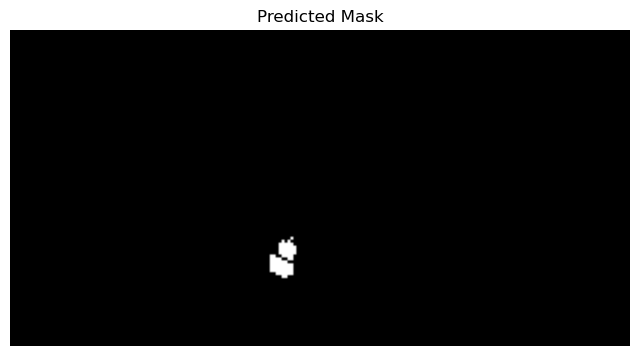

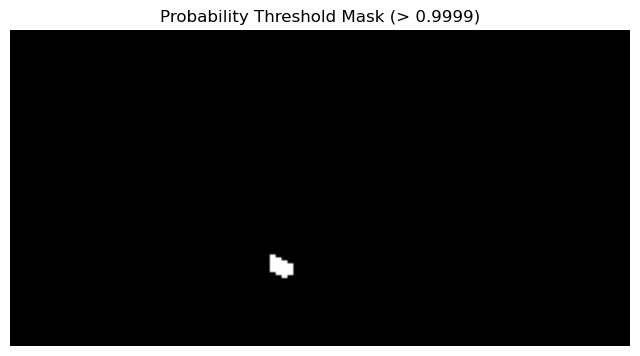

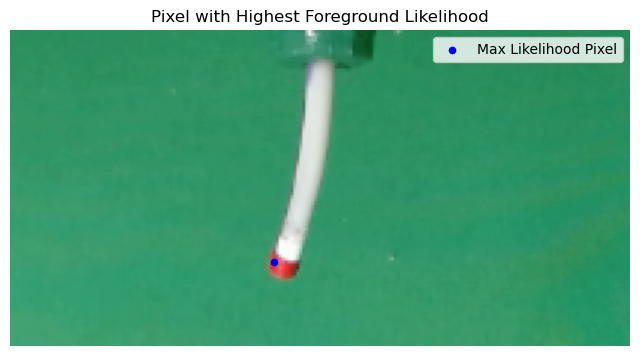

In [38]:
# Retest augmented model on the same test image

# Load image
test_image = cv2.imread("../tip_pose_images/cam0_1.png")

test_image = test_image[box0[1]:box0[3], box0[0]:box0[2]] # Crop for prediction
image_reshaped = test_image.reshape((-1, 3))
prediction = model_augmented.predict(image_reshaped)
mask = prediction.reshape((test_image.shape[0], test_image.shape[1]))


# Get the probability estimates for the foreground class (class 1)
proba = model_augmented.predict_proba(image_reshaped)[:, 1]
max_idx = np.argmax(proba)
max_y, max_x = np.unravel_index(max_idx, (test_image.shape[0], test_image.shape[1]))
print(f"Pixel with highest likelihood: ({max_x}, {max_y}) - Value: {test_image[max_y, max_x]}")\
# Compute a mask based on probability thresholding
prob_threshold = 0.9999
proba_image = proba.reshape(test_image.shape[:2])
prob_mask = (proba_image > prob_threshold).astype(np.uint8) * 255


# Visualize the point with the highest likelihood
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.title('Predicted Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

plt.figure(figsize=(8, 6))
plt.title(f'Probability Threshold Mask (> {prob_threshold})')
plt.imshow(prob_mask, cmap='gray')
plt.axis('off')
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.scatter([max_x], [max_y], color='blue', s=20, label='Max Likelihood Pixel')
plt.title('Pixel with Highest Foreground Likelihood')
plt.legend()
plt.axis('off')
plt.show()


# Voxel Carving

## Create Voxel Projection Lookup Table

In [33]:
import numpy as np
import cv2
import pickle

# Define voxel grid
VOXEL_SIZE = 0.0005
TOTAL_SIZE = 0.03  # Total size of the voxel grid in meters
N_X = int(TOTAL_SIZE / VOXEL_SIZE)  # Number of voxels along each axis
N_Y = int(TOTAL_SIZE / VOXEL_SIZE)  # Number of voxels along each axis
N_Z = int(TOTAL_SIZE / VOXEL_SIZE)  # Number of voxels along each axis
voxel_map = np.zeros((N_X, N_Y, N_Z), dtype=np.uint8)
origin = np.array([(N_X - 1) / 2, (N_Y - 1) / 2, 0]) * VOXEL_SIZE
# origin = np.array([0, 0, 0])  # Center of the voxel grid
voxel_coordinates = np.mgrid[0:N_X, 0:N_Y, 0:N_Z].reshape(3, -1).T * VOXEL_SIZE - origin
# print(voxel_coordinates)

# def voxel_index_to_cartesian(i, j, k):
#     '''Convert voxel indices to 3D coordinates in the voxel grid.
#     Coordinate frame origin is at center of x, y, and at 0 for z.
#     '''
#     x_coord = (i - (N_X - 1) / 2) * VOXEL_SIZE
#     y_coord = (j - (N_Y - 1) / 2) * VOXEL_SIZE
#     z_coord = k * VOXEL_SIZE
#     return np.array([x_coord, y_coord, z_coord])

# Load camera calibration data
with open("../camera_calibration/05-16-25/camera_calib_data.pkl", "rb") as f:
    camera_calib_data = pickle.load(f)

K = []  # Camera intrinsic matrix
d = []  # Distortion coefficients
R = []  # Extrinsic camera-world rotation matrix
T = []  # Extrinsic camera-world translation vector
for cam_num in range(2):
    K.append(
        camera_calib_data[f"cam{cam_num}"]["intrinsics"]["K"]
    )  # Camera intrinsic matrix
    d.append(
        camera_calib_data[f"cam{cam_num}"]["intrinsics"]["d"]
    )  # Distortion coefficients
    R.append(
        camera_calib_data[f"cam{cam_num}"]["extrinsics"]["R"]
    )  # Extrinsic camera-world rotation matrix
    T.append(
        camera_calib_data[f"cam{cam_num}"]["extrinsics"]["T"]
    )  # Extrinsic camera-world translation vector

# Define lookup table for two cameras voxel projection to image plane
voxel_lookup_table = np.zeros((2, N_X*N_Y*N_Z, 2), dtype=np.float32)

for cam_num in range(2):
        rvec, _ = cv2.Rodrigues(R[cam_num]) # Rotation vector from rotation matrix
        image_coordinates, _ = cv2.projectPoints(voxel_coordinates, rvec, T[cam_num], K[cam_num], d[cam_num])
        # print(f"Min image coordinates: {np.min(image_coordinates, axis=0)}")
        # print(f"Max image coordinates: {np.max(image_coordinates, axis=0)}")
        voxel_lookup_table[cam_num, :, :] = image_coordinates.reshape(-1, 2)


Occupied voxels: [[19 13 40]
 [19 13 41]
 [19 14 40]
 ...
 [31 37 10]
 [31 38  3]
 [31 38  4]]
Occupied points: [[-0.00525 -0.00825  0.02   ]
 [-0.00525 -0.00825  0.0205 ]
 [-0.00525 -0.00775  0.02   ]
 ...
 [ 0.00075  0.00375  0.005  ]
 [ 0.00075  0.00425  0.0015 ]
 [ 0.00075  0.00425  0.002  ]]


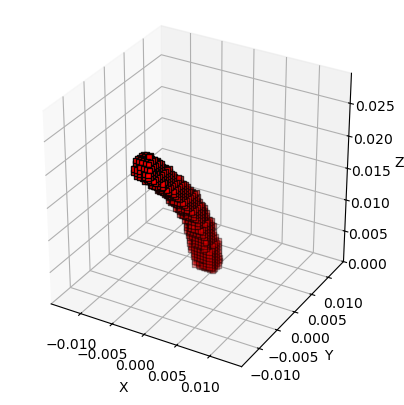

In [34]:
import cv2
import numpy as np
import glob
import os
import pickle
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

dir = "../tip_pose_images"
# cam0_path = sorted(glob.glob(f"{dir}/cam0_*.pkl"))
# cam1_path = sorted(glob.glob(f"{dir}/cam1_*.pkl"))
image_num = 1  # Change this to the desired image number
# cam0_file = f"{dir}/segmentation_results/cam0_{image_num}.pkl"
# cam1_file = f"{dir}/segmentation_results/cam1_{image_num}.pkl"
cam0_file = f"../pixel_classification/sam_masks_cam0_{image_num}.pkl"
cam1_file = f"../pixel_classification/sam_masks_cam1_{image_num}.pkl"

# for cam0_file, cam1_file in zip(cam0_path, cam1_path):

with open(cam0_file, "rb") as f:
    cam0_segmentation_results = pickle.load(f)
with open(cam1_file, "rb") as f:
    cam1_segmentation_results = pickle.load(f)
# cam0_mask = cam0_segmentation_results["masks"][0]
# cam1_mask = cam1_segmentation_results["masks"][0]
cam0_mask = cam0_segmentation_results[0]
cam1_mask = cam1_segmentation_results[0]

# Voxel carving
for index, (i, j, k) in enumerate(np.ndindex(N_X, N_Y, N_Z)):
    cam0_voxel_coords = voxel_lookup_table[0, index, :]
    cam1_voxel_coords = voxel_lookup_table[1, index, :]

    # Check if the voxel is visible in both cameras
    if cam0_mask[int(cam0_voxel_coords[1]), int(cam0_voxel_coords[0])] > 0 and \
        cam1_mask[int(cam1_voxel_coords[1]), int(cam1_voxel_coords[0])] > 0:
        voxel_map[i, j, k] = 1


# Visualize voxel map

# Extract the coordinates of occupied voxels
occupied_voxels = np.argwhere(voxel_map == 1)
print(f"Occupied voxels: {occupied_voxels}")
occupied_points = occupied_voxels * VOXEL_SIZE - origin
print(f"Occupied points: {occupied_points}")

# Create a 3D scatter plot with improved visualization

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Set axes limits to match voxel grid limits
x_min, y_min, z_min = voxel_coordinates.min(axis=0)
x_max, y_max, z_max = voxel_coordinates.max(axis=0)
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_zlim([z_min, z_max])

# Set labels and aspect ratio
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_box_aspect([x_max - x_min, y_max - y_min, z_max - z_min])

# Marker size: fill the voxel space (marker size is in points^2, so scale accordingly)
voxel_size = VOXEL_SIZE
# Calculate marker size in points^2 for scatter (approximate for visual fill)
# The following formula is a heuristic for matplotlib scatter in 3D:
marker_size = (72 * voxel_size / (x_max - x_min)) ** 2 * 10

ax.scatter(
    occupied_points[:, 0], occupied_points[:, 1], occupied_points[:, 2],
    c='r', marker='s', s=marker_size, edgecolor='k'
)

plt.show()

## 3D triangulation

In [155]:
# Load the prediction results for both camera images

image_num = 1
with open(f"../pixel_classification/pred_results_cam0_{image_num}.pkl", "rb") as f:
    cam0_pred_results = pickle.load(f)
with open(f"../pixel_classification/pred_results_cam1_{image_num}.pkl", "rb") as f:
    cam1_pred_results = pickle.load(f)

# Extract the red and other centroids from the prediction results
cam0_red_centroid = cam0_pred_results['red_centroid']
cam0_other_centroid = cam0_pred_results['other_centroid']
cam1_red_centroid = cam1_pred_results['red_centroid']
cam1_other_centroid = cam1_pred_results['other_centroid']

# Perform 3D triangulation to find the locations of red and other centroids in the world frame
def triangulate_point(cam0_point, cam1_point, K0, K1, R0, T0, R1, T1, d0, d1):
    """Triangulate a 3D point from two camera views."""
    # Convert rotation matrices to rotation vectors
    rvec0, _ = cv2.Rodrigues(R0)
    rvec1, _ = cv2.Rodrigues(R1)

    # Projection matrices for both cameras
    P0 = np.hstack((R0, T0.reshape(-1, 1)))
    P1 = np.hstack((R1, T1.reshape(-1, 1)))

    # Ensure inputs are proper float32 arrays
    cam0_point = np.array(cam0_point, dtype=np.float32).reshape(1, 1, 2)
    cam1_point = np.array(cam1_point, dtype=np.float32).reshape(1, 1, 2)

    # # Convert 2D points to normalized image coordinates
    # cam0_point_norm = np.linalg.inv(K0) @ np.array([cam0_point[0], cam0_point[1], 1])
    # cam1_point_norm = np.linalg.inv(K1) @ np.array([cam1_point[0], cam1_point[1], 1])
    cam0_point_norm = cv2.undistortPoints(cam0_point, K0, d0)
    cam1_point_norm = cv2.undistortPoints(cam1_point, K1, d1)

    # Triangulate the 3D point
    point_4d_homogeneous = cv2.triangulatePoints(P0, P1, cam0_point_norm[:2].reshape(-1, 1), cam1_point_norm[:2].reshape(-1, 1))
    point_3d = point_4d_homogeneous[:3] / point_4d_homogeneous[3]  # Convert from homogeneous to 3D coordinates
    return point_3d.flatten()

# Triangulate red centroid
red_centroid_world = triangulate_point(cam0_red_centroid, cam1_red_centroid, K[0], K[1], R[0], T[0], R[1], T[1], d[0], d[1])
print("Red centroid in world frame:", red_centroid_world)
# Reproject the red centroid back to camera images
reprojected_red_centroid_cam0, _ = cv2.projectPoints(
    red_centroid_world.reshape(1, 3), R[0], T[0], K[0], d[0]
)
reprojected_red_centroid_cam1, _ = cv2.projectPoints(
    red_centroid_world.reshape(1, 3), R[1], T[1], K[1], d[1]
)
reprojection_error_cam0 = np.linalg.norm(reprojected_red_centroid_cam0[0, 0] - cam0_red_centroid)
reprojection_error_cam1 = np.linalg.norm(reprojected_red_centroid_cam1[0, 0] - cam1_red_centroid)
print("Reprojection error for red centroid in cam0:", reprojection_error_cam0)
print("Reprojection error for red centroid in cam1:", reprojection_error_cam1)

# Triangulate other centroid
other_centroid_world = triangulate_point(cam0_other_centroid, cam1_other_centroid, K[0], K[1], R[0], T[0], R[1], T[1], d[0], d[1])
print("Other centroid in world frame:", other_centroid_world)

Red centroid in world frame: [-0.03882012 -0.00572799  0.04008245]
Reprojection error for red centroid in cam0: 50.95042499096883
Reprojection error for red centroid in cam1: 51.83094693579234
Other centroid in world frame: [-0.05157012 -0.01076992  0.04429872]


In [ ]:
# Get undistorted and backprojected rays in world coordinates
def get_camera_ray(pixel, K, R, T, d):
    pt = np.array(pixel, dtype=np.float32).reshape(1, 1, 2)
    undistorted = cv2.undistortPoints(pt, K, d)
    ray_cam = undistorted.reshape(3)
    ray_cam /= np.linalg.norm(ray_cam)

    # Transform to world
    ray_world = R.T @ ray_cam.reshape(3, 1)
    origin_world = -R.T @ T.reshape(3, 1)
    return origin_world.flatten(), ray_world.flatten()

origin0, dir0 = get_camera_ray(cam0_red_centroid, K[0], R[0], T[0], d[0])
origin1, dir1 = get_camera_ray(cam1_red_centroid, K[1], R[1], T[1], d[1])


## Voxel Map to Shape

Base coordinate from z slicing: [0.00025 0.00325 0.0005 ]
[0.00025 0.00325 0.0005 ]


C:\Users\jlim\AppData\Local\Temp\ipykernel_16652\1680089343.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


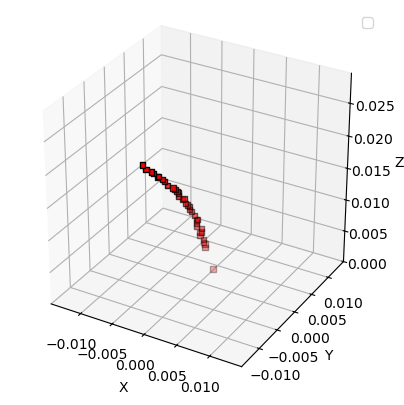

In [36]:
from skimage.morphology import skeletonize

# Calculate base point as the centroid of the first z slice of the voxel map
z_values = occupied_points[:, 2]
unique_z = np.unique(z_values)
centerline_points = []

for z in np.sort(unique_z):
    slice_points = occupied_points[np.isclose(z_values, z)]
    if len(slice_points) > 0:
        mean_xy = slice_points[:, :2].mean(axis=0)
        centerline_points.append([mean_xy[0], mean_xy[1], z])

centerline_points = np.array(centerline_points)
base_coord = centerline_points[0]  # Use the first point as the base coordinate
print("Base coordinate from z slicing:", base_coord)

# Skeletonize voxel map to find centerline
skeleton = skeletonize(voxel_map)
skeleton_coords = np.argwhere(skeleton == 1) * VOXEL_SIZE - origin # 3D coordinates of skeleton points
# add base coordinate to skeleton points
skeleton_coords = np.vstack((skeleton_coords, base_coord))
# Order skeleton points by their z-coordinate
skeleton_coords = skeleton_coords[np.argsort(skeleton_coords[:, 2])]
print(skeleton_coords[0])  # Print the first skeleton point

# Visualize skeleton in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Set axes limits to match voxel grid limits
x_min, y_min, z_min = voxel_coordinates.min(axis=0)
x_max, y_max, z_max = voxel_coordinates.max(axis=0)
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_zlim([z_min, z_max])

# Set labels and aspect ratio
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_box_aspect([x_max - x_min, y_max - y_min, z_max - z_min])
# Marker size: fill the voxel space (marker size is in points^2, so scale accordingly)
marker_size = (72 * VOXEL_SIZE / (x_max - x_min)) ** 2 * 10

ax.scatter(
    skeleton_coords[:, 0], skeleton_coords[:, 1], skeleton_coords[:, 2],
    c='r', marker='s', s=marker_size, edgecolor='k'
)
# # Visualize red and other centroids in the world frame
# ax.scatter([red_centroid_world[0]], [red_centroid_world[1]], [red_centroid_world[2]], color='r', s=80, label='Red Centroid')
# ax.scatter(*other_centroid_world, color='b', s=80, label='Other Centroid')
ax.legend()

plt.show()

## Spline interpolation

Base point from spline: [7.19387360e-05 3.13306564e-03 6.46209003e-04]
Tip point from spline: [-0.00459321 -0.00708766  0.02051395]


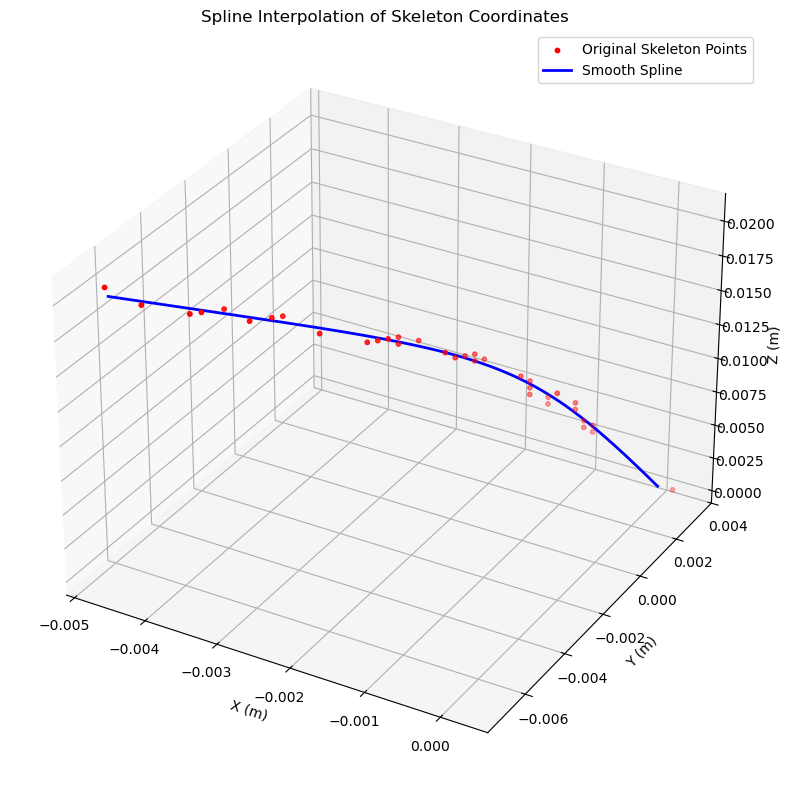

In [53]:
from scipy.interpolate import splprep, splev
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

# Extract x, y, z coordinates from skeleton_coords
x, y, z = skeleton_coords[:, 0], skeleton_coords[:, 1], skeleton_coords[:, 2]

# Fit a spline to the skeleton coordinates
tck, u = splprep(skeleton_coords.T)  # s is the smoothing factor
u_fine = np.linspace(0, 1, 500)  # Generate fine parameter values for smooth interpolation
spline = np.array(splev(u_fine, tck))
base_point = spline[:, 0]  # Use the first point as the base point for the spline
tip_point = spline[:, -1]  # Use the last point as the tip point for the spline
print("Base point from spline:", base_point)
print("Tip point from spline:", tip_point)
# print(np.array(spline).shape)
# Visualize the original skeleton and the smooth spline
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot original skeleton points
ax.scatter(x, y, z, color='red', label='Original Skeleton Points', s=10)

# Plot smooth spline
ax.plot(spline[0,:], spline[1,:], spline[2,:], color='blue', label='Smooth Spline', linewidth=2)

# Set labels and aspect ratio
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('Spline Interpolation of Skeleton Coordinates')
ax.legend()
plt.tight_layout()
plt.show()

Base coordinate from skeleton (closest to z=0): [0.00025 0.00325 0.0005 ]
Tip coordinate (farthest from z=0): [-0.00475 -0.00675  0.0205 ]


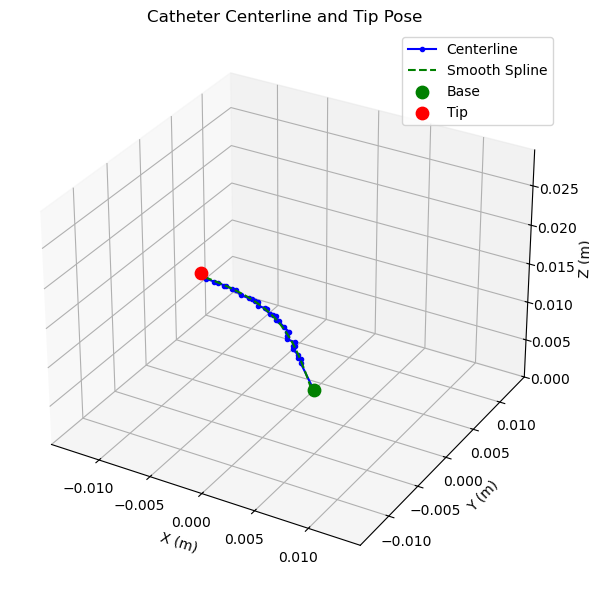

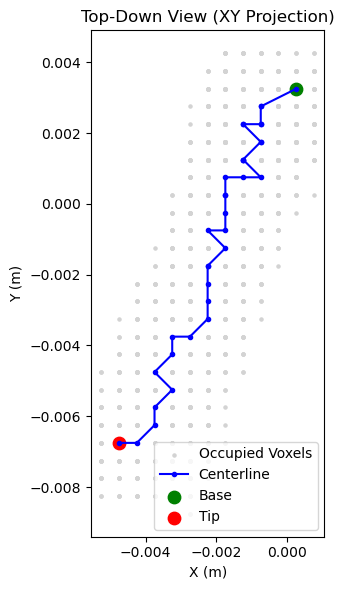

base_img0: [317.12903 119.69353]
tip_img0: [300.854   188.15504]
base_img1: [284.331  185.3975]
tip_img1: [253.19821 238.64871]


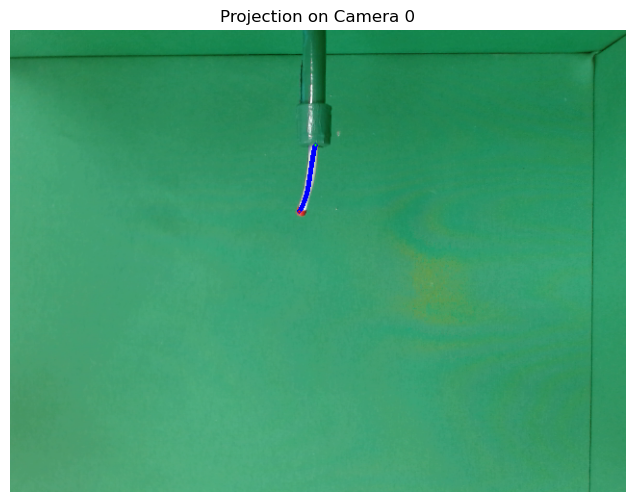

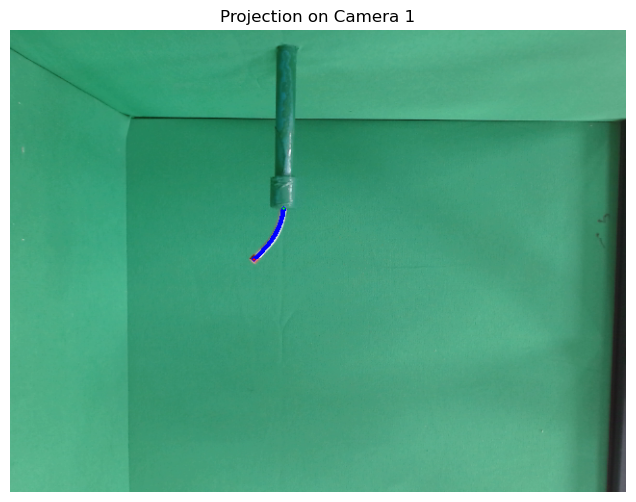

In [54]:
# Base and tip according to z ordering
base_coord_skel = skeleton_coords[0]
tip_coord = skeleton_coords[-1]

print("Base coordinate from skeleton (closest to z=0):", base_coord_skel)
print("Tip coordinate (farthest from z=0):", tip_coord)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot centerline
ax.plot(skeleton_coords[:, 0], skeleton_coords[:, 1], skeleton_coords[:, 2], 'b.-', label='Centerline')
ax.plot(spline[0,:], spline[1,:], spline[2,:], 'g--', label='Smooth Spline')

# Plot base and tip
ax.scatter(*base_coord, color='g', s=80, label='Base')
ax.scatter(*tip_coord, color='r', s=80, label='Tip')

# Set axes limits
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_zlim([z_min, z_max])

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('Catheter Centerline and Tip Pose')
ax.legend()
plt.tight_layout()
plt.show()

# Top-down view: projection onto the XY plane
fig2 = plt.figure(figsize=(6, 6))
ax2 = fig2.add_subplot(111)

# Plot all occupied points as background
ax2.scatter(occupied_points[:, 0], occupied_points[:, 1], c='lightgray', s=5, label='Occupied Voxels')

# Plot centerline
ax2.plot(skeleton_coords[:, 0], skeleton_coords[:, 1], 'b.-', label='Centerline')

# Plot base and tip and avg point
ax2.scatter(base_coord[0], base_coord[1], color='g', s=80, label='Base')
ax2.scatter(tip_coord[0], tip_coord[1], color='r', s=80, label='Tip')
# ax2.scatter(avg_point[0], avg_point[1], color='orange', s=80, label='Average Point')

# # Plot tangent vector at tip (projected to xy)
# tip_xy = tip_coord[:2]
# tangent_xy = tangent[:2] / np.linalg.norm(tangent[:2])
# arrow_scale_xy = tip_arrow_scale * 5  # scale for visibility
# ax2.arrow(
#     tip_xy[0], tip_xy[1],
#     tangent_xy[0] * arrow_scale_xy, tangent_xy[1] * arrow_scale_xy,
#     head_width=0.0003, head_length=0.0005, fc='m', ec='m', label='Tip Tangent'
# )

ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_title('Top-Down View (XY Projection)')
ax2.set_aspect('equal')
ax2.legend()
plt.tight_layout()
plt.show()

# Project 3D points (centerline, base, tip) onto both camera images

def project_points(points_3d, rvec, tvec, camera_matrix, dist_coeffs=None):
    """Project 3D points to 2D image coordinates using OpenCV."""
    if dist_coeffs is None:
        dist_coeffs = np.zeros((5, 1))
    points_2d, _ = cv2.projectPoints(points_3d, rvec, tvec, camera_matrix, dist_coeffs)
    return points_2d.squeeze()

# Prepare 3D points for projection
centerline_3d = spline.astype(np.float32)
base_3d = base_point.reshape(1, 3).astype(np.float32)
tip_3d = tip_point.reshape(1, 3).astype(np.float32)

# Project to cam0
rvec0 = cv2.Rodrigues(R[0])[0]  # Convert rotation matrix to rotation vector
centerline_img0 = project_points(centerline_3d, rvec0, T[0], K[0], d[0])
base_img0 = project_points(base_3d, rvec0, T[0], K[0], d[0])
tip_img0 = project_points(tip_3d, rvec0, T[0], K[0], d[0])

# Project to cam1
rvec1 = cv2.Rodrigues(R[1])[0]  # Convert rotation matrix to rotation vector
centerline_img1 = project_points(centerline_3d, rvec1, T[1], K[1], d[1])
base_img1 = project_points(base_3d, rvec1, T[1], K[1], d[1])
tip_img1 = project_points(tip_3d, rvec1, T[1], K[1], d[1])

print("base_img0:", base_img0)
print("tip_img0:", tip_img0)
print("base_img1:", base_img1)
print("tip_img1:", tip_img1)

# # Project tangent vector at tip into both images
# # Create a 3D point a small step along the tangent from the tip
# tangent_length = 0.005  # 5mm for visualization
# tip_tangent_3d = (tip_coord + tangent * tangent_length).reshape(1, 3).astype(np.float32)

# # Project tangent endpoint to cam0 and cam1
# tip_tangent_img0 = project_points(tip_tangent_3d, rvec0, tvec0, K0, d0)
# tip_tangent_img1 = project_points(tip_tangent_3d, rvec1, tvec1, K1, d1)

# Visualize on cam0 image
img0 = cv2.imread(f"../tip_pose_images/cam0_{image_num}.png")
img1 = cv2.imread(f"../tip_pose_images/cam1_{image_num}.png")
img0_vis = img0.copy()
for pt in centerline_img0.astype(int):
    cv2.circle(img0_vis, tuple(pt), 2, (255, 0, 0), -1)
cv2.circle(img0_vis, tuple(base_img0.astype(int)), 1, (0, 255, 0), -1)
cv2.circle(img0_vis, tuple(tip_img0.astype(int)), 1, (0, 0, 255), -1)
# # Draw tangent vector at tip
# pt1 = tuple(tip_img0.astype(int))
# pt2 = tuple(tip_tangent_img0.astype(int))
# cv2.arrowedLine(img0_vis, pt1, pt2, (255, 0, 255), 2, tipLength=0.3)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img0_vis, cv2.COLOR_BGR2RGB))
plt.title('Projection on Camera 0')
plt.axis('off')
plt.show()

# Visualize on cam1 image
img1_vis = img1.copy()
for pt in centerline_img1.astype(int):
    cv2.circle(img1_vis, tuple(pt), 2, (255, 0, 0), -1)
cv2.circle(img1_vis, tuple(base_img1.astype(int)), 1, (0, 255, 0), -1)
cv2.circle(img1_vis, tuple(tip_img1.astype(int)), 1, (0, 0, 255), -1)
# # Draw tangent vector at tip
# pt1_1 = tuple(tip_img1.astype(int))
# pt2_1 = tuple(tip_tangent_img1.astype(int))
# cv2.arrowedLine(img1_vis, pt1_1, pt2_1, (255, 0, 255), 2, tipLength=0.3)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img1_vis, cv2.COLOR_BGR2RGB))
plt.title('Projection on Camera 1')
plt.axis('off')
plt.show()

# Testing esimator class

/home/arclab/repos/segment-anything/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


TypeError: 'NoneType' object is not subscriptable

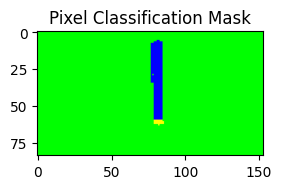

In [1]:
from catheter_shape_estimator import CatheterShapeEstimator
import cv2
from matplotlib import pyplot as plt
import glob
import os
import numpy as np

# ---------- Parameters ----------
NUM_CLASSES = 3  # Green, Red, Other
BOX_COLORS = [(0,255,0), (0,0,255), (255,255,0)]  # BGR for green/red/other
CLASS_NAMES = ['Green', 'Red', 'Other']

estimator = CatheterShapeEstimator()

# Load example images (replace with actual image loading)
# img_dir = "C:\\Users\\jlim\\OneDrive - Cor Medical Ventures\\Documents\\Channel Robotics\\Catheter Calibration Data\\LC_v3_06_04_25_test\\image_snapshots"
# img_dir = "/home/arclab/catkin_ws/src/Catheter-Control/resources/CalibrationData/NA_06_13_25_test/image_snapshots"
# img0_paths = sorted(glob.glob(os.path.join(img_dir, "cam_0", "*.png")))
# img1_paths = sorted(glob.glob(os.path.join(img_dir, "cam_1", "*.png")))
img_dir = "../tip_pose_images/LC_v4"
img0_paths = sorted(glob.glob(os.path.join(img_dir, "cam0_*.png")))
img1_paths = sorted(glob.glob(os.path.join(img_dir, "cam1_*.png")))
img0 = cv2.imread(img0_paths[0])
img1 = cv2.imread(img1_paths[0])

box0 = (216, 117, 424, 216)
box1 = (201, 180, 354, 264)

# Crop images to the bounding boxes
img0 = img0[box0[1]:box0[3], box0[0]:box0[2]]
img1 = img1[box1[1]:box1[3], box1[0]:box1[2]]

img = img1

class_mask, prob_mask = estimator.color_classify(img)
red_mask = class_mask == 1  # Red class mask
other_mask = class_mask == 2  # Other class mask
red_mask = estimator.open_close_mask(red_mask, kernel_size=5)  # Morphological operations to clean mask
other_mask = estimator.open_close_mask(other_mask, kernel_size=5)  # Morphological operations to clean mask
red_centroid = estimator.get_centroid(red_mask)
other_centroid = estimator.get_centroid(other_mask)
max_prob_idx, max_prob = estimator.get_max_prob_pixel(prob_mask)
max_idx_red = max_prob_idx[1]
max_idx_other = max_prob_idx[2]

def colorize_mask(mask):
    colors = [[0, 255, 0],  # Green
            [255, 0, 0],  # Red
            [0, 0, 255]]  # Other (Blue)
    output = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for idx, color in enumerate(BOX_COLORS):
        output[mask == idx] = color
    return output

segmentation_overlay = colorize_mask(class_mask)

# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.title("Original Image")
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# # plt.scatter([max_idx_red[1]], [max_idx_red[0]], color='red', s=50, label='Most Likely Red Pixel')
# # plt.scatter([max_idx_other[1]], [max_idx_other[0]], color='blue', s=50, label='Most Likely Other Pixel')
# plt.scatter([red_centroid[0]], [red_centroid[1]], marker='x', color='orange', s=50, label='Red Centroid')
# plt.scatter([other_centroid[0]], [other_centroid[1]], marker='x', color='purple', s=50, label='Other Centroid')
# plt.legend()
# plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Pixel Classification Mask")
plt.imshow(segmentation_overlay)
# plt.scatter([max_idx_red[1]], [max_idx_red[0]], color='red', s=50, label='Most Likely Red Pixel')
# plt.scatter([max_idx_other[1]], [max_idx_other[0]], color='blue', s=50, label='Most Likely Other Pixel')
# plt.scatter([red_centroid[0]], [red_centroid[1]], marker='x', color='orange', s=50, label='Red Centroid')
plt.scatter([other_centroid[0]], [other_centroid[1]], marker='x', color='purple', s=50, label='Other Centroid')
plt.legend()
plt.axis('off')

plt.tight_layout()
plt.show()


# fg_labels = [1, 2]
# bg_labels = [0]
# point_coords = max_prob_idx  # Use 'other' class pixel
# point_coords = np.flip(point_coords, axis=1)  # Switch x, y coordinates
# point_labels = np.zeros(point_coords.shape[0])
# point_labels[fg_labels] = 1  # Label for the point TODO:

point_coords = np.array([other_centroid])
point_labels = np.array([1])
print("Point Coords:", point_coords)
print("Point Labels:", point_labels)
sam_masks = estimator.sam_segment(img, point_coords, point_labels)

# Visualize SAM segmentation result with point_coords
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(sam_masks[0], alpha=0.5, cmap='Reds')
plt.scatter(point_coords[:, 0], point_coords[:, 1], color='yellow', s=50, label='Point Coords')
plt.title("SAM Segmentation Result")
plt.legend()
plt.axis('off')
plt.show()

# Visualize binary SAM mask
plt.figure(figsize=(8, 6))
plt.imshow(sam_masks[0], cmap='gray')
plt.title("Binary SAM Mask")
plt.axis('off')
plt.show()

/home/arclab/repos/segment-anything/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


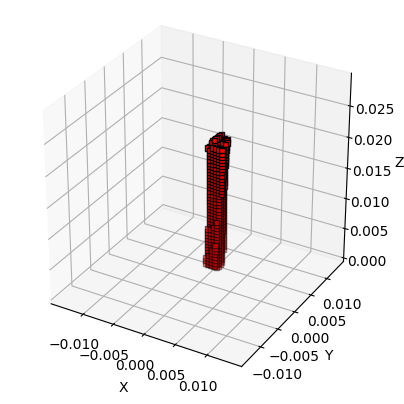

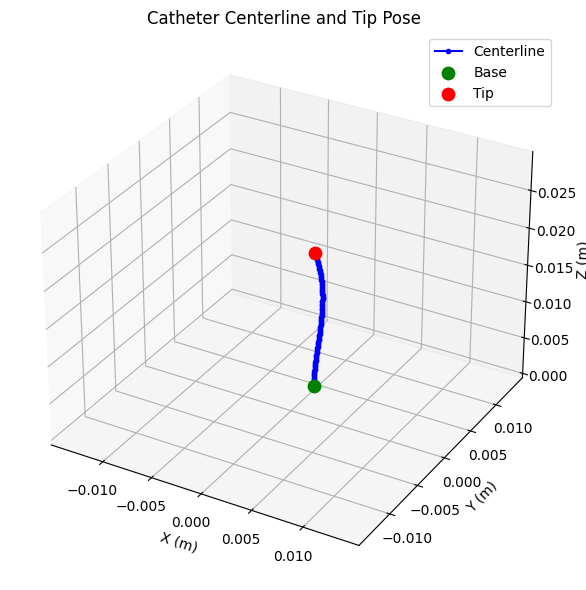

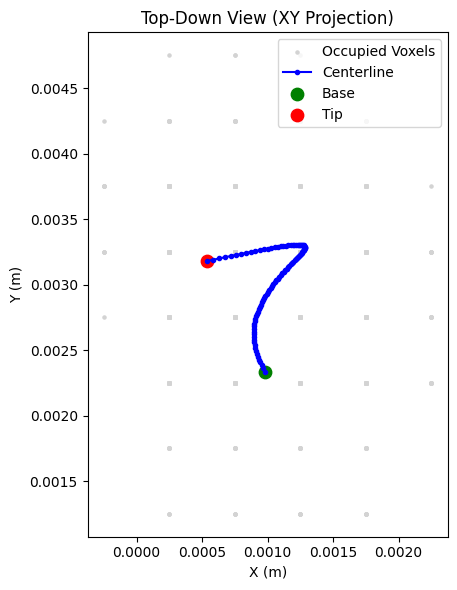

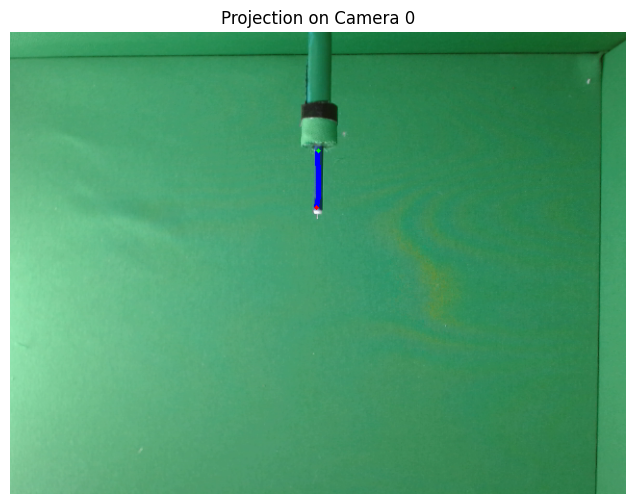

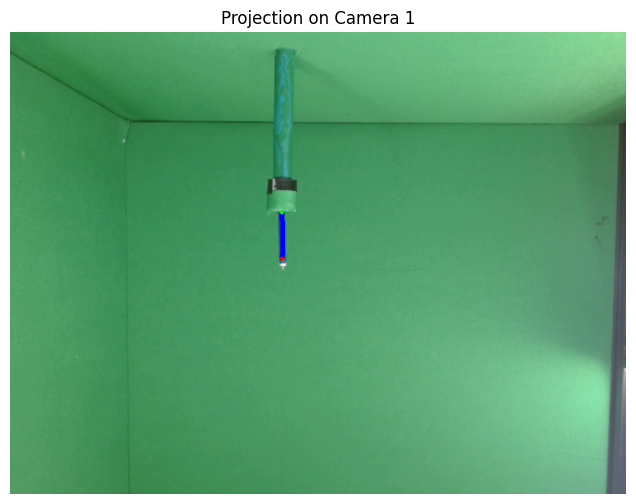

Estimated Tip Pose: ([(-0.00044600383210621276, 0.0008421805222168311, 0.017407920516693466)], [(0.10937990857021829, 2.0578286900271667)])


ValueError: not enough values to unpack (expected 3, got 1)

In [3]:
from catheter_shape_estimator import CatheterShapeEstimator
import cv2
from matplotlib import pyplot as plt
import glob
import os
import numpy as np

# ---------- Parameters ----------
NUM_CLASSES = 3  # Green, Red, Other
BOX_COLORS = [(0,255,0), (0,0,255), (255,255,0)]  # BGR for green/red/other
CLASS_NAMES = ['Green', 'Red', 'Other']

estimator = CatheterShapeEstimator()

# Load example images (replace with actual image loading)
# img_dir = "C:\\Users\\jlim\\OneDrive - Cor Medical Ventures\\Documents\\Channel Robotics\\Catheter Calibration Data\\LC_v3_06_04_25_test\\image_snapshots"
# img0_paths = sorted(glob.glob(os.path.join(img_dir, "cam_0", "*.png")))
# img1_paths = sorted(glob.glob(os.path.join(img_dir, "cam_1", "*.png")))
# img0 = cv2.imread(img0_paths[1])
# img1 = cv2.imread(img1_paths[1])

img_dir = "../tip_pose_images/LC_v4"
img0_paths = sorted(glob.glob(os.path.join(img_dir, "cam0_*.png")))
img1_paths = sorted(glob.glob(os.path.join(img_dir, "cam1_*.png")))
img0 = cv2.imread(img0_paths[0])
img1 = cv2.imread(img1_paths[0])

tip_pose = estimator.estimate_tip_pose(images=[(img0, img1)], prompt_type="centroid", visualize=True)
print("Estimated Tip Pose:", tip_pose)
angles = estimator.tip_pos_to_angles(tip_pose)
print("Estimated Angles (Theta, Phi):", np.degrees(angles[0]))
